In [35]:
import layout_scanner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk.corpus import stopwords
import matplotlib.image as mpimg

In [36]:
def text_image(file, outputfile, img_folder):
    layout_scanner.get_pages(file, '',  outputfile, img_folder)
    with open(outputfile, 'r') as f:
        lines = f.readlines()

    import re
    # array of text/image line
    arr_li = []
    for li in lines:
        if 'START-PAGE' in li:
            page = li.split(' ')[1]
        elif  'TextBoxH' in li:
            arr_li.append([page, 'T',li.split(' ')[0].split('(')[1].split(')')[0], \
                           li.split(',')[0].split(' ')[1],li.split(',')[1], \
                          li.split(',')[2],li.split(',')[3].split(' ')[0], ' '.join([i for i in li.split(' ')[2:]]), ''])
        elif 'LTImage' in li:
            arr_li.append([page, 'I',li.split(' ')[0].split('(')[1].split(')')[0][2:], \
                           li.split(',')[0].split(' ')[1],li.split(',')[1], \
                           li.split(',')[2],li.split(',')[3].split(' ')[0], page+ \
                           li.split(' ')[0].split('(')[1].split(')')[0]+'.png', ''])

    arr_li = np.asarray(arr_li)
    df_li = pd.DataFrame(arr_li, columns=['page', 'class', 'class-order-in-page','xmin', 'ymin', 'xmax', 'ymax', 'content','link-to'])
    df_li['content'] = df_li['content'].apply(lambda x:  None if re.match(r"^\'(.\\n|CNEWS.FR)", x) else x).tolist()
    df_li = df_li.dropna().reset_index(drop=True)
    df_li['content'] = df_li['content'].apply(lambda x: re.sub(r'(\\n|\>\s|\')', ' ', x))
    df = df_li
    df[['page', 'class-order-in-page']] = df[['page', 'class-order-in-page']].astype('int')
    df[[ 'xmin', 'ymin', 'xmax', 'ymax']] = df[['xmin', 'ymin', 'xmax', 'ymax']].astype('float')
    
    df_copy = df.copy()
    
    for page in df['page'].unique():
        df_page = df[df['page']==page]       
        df_box = df_page[df_page['class']=='T']
        df_img = df_page[df_page['class']=='I']
        for ord_img in df_img['class-order-in-page'].unique():
            for ord_box in  df_box['class-order-in-page'].unique():
                img_ymin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,4])
                box_ymax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,6])
                img_xmin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,3])
                box_xmin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,3])
                if  (abs(img_ymin - box_ymax) < 10) and (abs(img_xmin - box_xmin) < 10):
                    df.iloc[df_box[df_box['class-order-in-page']==ord_box].index.values.astype(int)[0],8] =  \
                    df.iloc[df_box[df_box['class-order-in-page']==ord_box].index.values.astype(int)[0],8]+' '+ \
                    df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],7]
                    df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],8] =  \
                    df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],8]+' '+\
                    str(page)+'Text'+str(ord_box)
    tokenizer = RegexpTokenizer(r'\w+')
    df['content'] = df['content'].apply(lambda x: tokenizer.tokenize(x))
    #.apply(lambda x: [nltk.stem.snowball.FrenchStemmer().stem(i) for i in x])
    a = set(stopwords.words('french'))
    new_stopwords = ['a', 'être', 'avoir']
    a = a.union(set(new_stopwords))
    df['content'] = df['content'].apply(lambda x: [nltk.stem.snowball.FrenchStemmer().stem(i) for i in x]) \
    .apply(lambda x: [i for i in x if i not in a])

    
    for page in df['page'].unique():
        df_page = df[df['page']==page]       
        df_box = df_page[df_page['class']=='T']
        df_img1 = df_page[df_page['class']=='I']
        df_img = df_img1[df_img1['link-to']!='']
        for ord_img in df_img['class-order-in-page'].unique():
            for ord_box in  df_box['class-order-in-page'].unique():
                img_ymin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,4])
                img_xmin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,3])
                img_xmax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,5])
                img_ymax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,6])
                box_xmin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,3])
                box_ymin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,4])
                box_xmax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,5])
                box_ymax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,6])
                if  ( ((img_xmin - box_xmax) < 20) and ((img_xmin - box_xmax) > 0) )  \
                     and (not ( (img_ymax<box_ymin) or (img_ymin > box_ymax) ) ):
                    ord_box2 = int(df_img[df_img['class-order-in-page']==ord_img].iloc[0,8].split("Text")[1])
                    match = set(df_box[df_box['class-order-in-page']==ord_box].iloc[0,7]) \
                     .intersection(set(df_box[df_box['class-order-in-page']==ord_box2].iloc[0, 7]))
                    if (len(list(match)) >=1):
                        if len(list(match))==1 :
                            if not re.match(r'[a-zA-Z]', list(match)[0]) :
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img] \
                                                                 .index.values.astype(int)[0],7]])
                        else:
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img]\
                                                                 .index.values.astype(int)[0],7]])

                                                                                                                 

    for page in df['page'].unique():
        df_page = df[df['page']==page]       
        df_box = df_page[df_page['class']=='T']
        df_img1 = df_page[df_page['class']=='I']
        df_img = df_img1[df_img1['link-to']!='']
        for ord_img in df_img['class-order-in-page'].unique():
            for ord_box in  df_box['class-order-in-page'].unique():
                img_ymin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,4])
                img_xmin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,3])
                img_xmax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,5])
                img_ymax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,6])
                box_xmin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,3])
                box_ymin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,4])
                box_xmax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,5])
                box_ymax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,6])
                if  ( ((img_xmin - box_xmax) < 20) and ((img_xmin - box_xmax) > 0) )  and (not ( (img_ymax<box_ymin) or (img_ymin > box_ymax) ) ):
                    ord_box2 = int(df_img[df_img['class-order-in-page']==ord_img].iloc[0,8].split("Text")[1])
                    match = set(df_box[df_box['class-order-in-page']==ord_box].iloc[0,7]).intersection(set(df_box[df_box['class-order-in-page']==ord_box2].iloc[0, 7]))
                    if (len(list(match)) >=1):
                        if len(list(match))==1 :
                            if not re.match(r'[a-zA-Z]', list(match)[0]) :
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],7]])
                        else:
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],7]])
    for page in df['page'].unique():
        df_page = df[df['page']==page]       
        df_box = df_page[df_page['class']=='T']
        df_img1 = df_page[df_page['class']=='I']
        df_img = df_img1[df_img1['link-to']!='']
        for ord_img in df_img['class-order-in-page'].unique():
            for ord_box in  df_box['class-order-in-page'].unique():
                img_ymin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,4])
                img_xmin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,3])
                img_xmax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,5])
                img_ymax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,6])
                box_xmin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,3])
                box_ymin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,4])
                box_xmax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,5])
                box_ymax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,6])
                if  ( ((box_xmin - img_xmax) < 20) and ((box_xmin - img_xmax) > 0) )  and (not ( (img_ymax<box_ymin) or (img_ymin > box_ymax) ) ):
                    ord_box2 = int(df_img[df_img['class-order-in-page']==ord_img].iloc[0,8].split("Text")[1])
                    match = set(df_box[df_box['class-order-in-page']==ord_box].iloc[0,7]).intersection(set(df_box[df_box['class-order-in-page']==ord_box2].iloc[0, 7]))
                    if (len(list(match)) >=1):
                        if len(list(match))==1 :
                            if not re.match(r'[a-zA-Z]', list(match)[0]) :
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],7]])
                        else:
                                     df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],7]])

    for page in df['page'].unique():
        df_page = df[df['page']==page]       
        df_box = df_page[df_page['class']=='T']
        df_img1 = df_page[df_page['class']=='I']
        df_img = df_img1[df_img1['link-to']!='']
        for ord_img in df_img['class-order-in-page'].unique():
            for ord_box in  df_box['class-order-in-page'].unique():
                img_ymin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,4])
                img_xmin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,3])
                img_xmax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,5])
                img_ymax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,6])
                box_xmin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,3])
                box_ymin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,4])
                box_xmax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,5])
                box_ymax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,6])
                if  ( ((img_ymin - box_ymax) < 40) and ((img_ymin - box_ymax) > 20) )  and (not ( (img_xmax<box_xmin) or (img_xmin > box_xmax) ) ):
                    ord_box2 = int(df_img[df_img['class-order-in-page']==ord_img].iloc[0,8].split("Text")[1])
                    match = set(df_box[df_box['class-order-in-page']==ord_box].iloc[0,7]).intersection(set(df_box[df_box['class-order-in-page']==ord_box2].iloc[0, 7]))
                    if (len(list(match)) >=1):
                        if len(list(match))==1 :
                            if not re.match(r'[a-zA-Z]', list(match)[0]) :
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],7]])
                        else:
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],7]])
    for page in df['page'].unique():
        df_page = df[df['page']==page]       
        df_box = df_page[df_page['class']=='T']
        df_img1 = df_page[df_page['class']=='I']
        df_img = df_img1[df_img1['link-to']!='']
        for ord_img in df_img['class-order-in-page'].unique():
            for ord_box in  df_box['class-order-in-page'].unique():
                img_ymin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,4])
                img_xmin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,3])
                img_xmax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,5])
                img_ymax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,6])
                box_xmin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,3])
                box_ymin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,4])
                box_xmax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,5])
                box_ymax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,6])
                if  ( ((box_ymin - img_ymax) < 20) and ((box_ymin - img_ymax) > 0) )  and (not ( (img_xmax<box_xmin) or (img_xmin > box_xmax) ) ):
                    ord_box2 = int(df_img[df_img['class-order-in-page']==ord_img].iloc[0,8].split("Text")[1])
                    match = set(df_box[df_box['class-order-in-page']==ord_box].iloc[0,7]).intersection(set(df_box[df_box['class-order-in-page']==ord_box2].iloc[0, 7]))
                    if (len(list(match)) >=1):
                        if len(list(match))==1 :
                            if not re.match(r'[a-zA-Z]', list(match)[0]) :
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],7]])
                        else:
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],7]])

    for page in df['page'].unique():
        df_page = df[df['page']==page]       
        df_box = df_page[df_page['class']=='T']
        df_img1 = df_page[df_page['class']=='I']
        df_img = df_img1[df_img1['link-to']!='']
        for ord_img in df_img['class-order-in-page'].unique():
            for ord_box in  df_box['class-order-in-page'].unique():
                img_ymin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,4])
                img_xmin = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,3])
                img_xmax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,5])
                img_ymax = np.squeeze(df_img[df_img['class-order-in-page']==ord_img].iloc[:,6])
                box_xmin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,3])
                box_ymin = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,4])
                box_xmax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,5])
                box_ymax = np.squeeze(df_box[df_box['class-order-in-page']==ord_box].iloc[:,6])
                ord_box2 = int(df_img[df_img['class-order-in-page']==ord_img].iloc[0,8].split("Text")[1])
                if  (not ( ((img_ymin - box_ymax) > 0) or ((box_ymin - img_ymax) > 0) or ((img_xmin - box_xmax) > 0) or ((box_xmin - img_xmax) > 0)  ) ) \
                    and (ord_box != ord_box2):
                    match = set(df_box[df_box['class-order-in-page']==ord_box].iloc[0,7]).intersection(set(df_box[df_box['class-order-in-page']==ord_box2].iloc[0, 7]))
                    if (len(list(match)) >=1):
                        if len(list(match))==1 :
                            if not re.match(r'[a-zA-Z]', list(match)[0]) :
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],7]])
                        else:
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8] =  \
                                    df.iloc[df_box[df_box['class-order-in-page']==ord_box2].index.values.astype(int)[0],8]+' '+ \
                                    ' '.join([i for i in df.iloc[df_img[df_img['class-order-in-page']==ord_img].index.values.astype(int)[0],7]])
    print(df_copy.shape)
    return df, df_copy

In [56]:
def find_image(mot_cle, df, df2):
    df['content'] = df2['content']
    tmp = df[df['content'].str.contains(mot_cle)]
    if tmp.shape[0] == 0:
        print('No information found')
    else:
        if tmp[tmp['link-to'] !=''].shape[0] == 0:
            print('Yop, no related photo, please read text below:')
            for i in range(tmp.shape[0]):
                print('----------------------------------------------')
                print('text from page '+str(tmp.iloc[i, 0])+' :')
                print(df2.iloc[tmp.index[i], 7])           
        else:
            img = tmp[tmp['link-to'] !=''].iloc[0,8]
            img=mpimg.imread('Test/images/'+img.split(' ')[1].replace('Im', '_Im'))
            imgplot = plt.imshow(img)
            plt.show()
            print('text from page '+str(tmp[tmp['link-to'] !=''].iloc[0,0])+' :')
            print(df2.iloc[tmp[tmp['link-to'] !=''].index[0], 7])      
            for i in range(tmp.shape[0]):
                print('----------------------------------------------')
                print('text from page '+str(tmp.iloc[i, 0])+' :')
                print(df2.iloc[tmp.index[i], 7])      

In [38]:
outputfile = 'Test/output.txt'
img_folder = 'Test/images'
file = 'Test/CNEWS-20190902-0.pdf'
df, df_copy= text_image(file, outputfile, img_folder)

Im3
cannot identify image file <_io.BytesIO object at 0x7f6aa8a34728>
Im3
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35830>
Im22
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35830>
Im23
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35830>
Im24
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35830>
Im25
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35830>
Im26
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35830>
Im27
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35830>
Im28
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35830>
Im29
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35830>
Im30
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35830>
Im31
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35830>
Im4
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35410>
Im5
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35410>
Im6
cannot

Im0
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35a40>
Im3
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35a40>
Im7
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35a40>
Im11
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35a40>
Im12
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35a40>
Im14
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35a40>
Im16
cannot identify image file <_io.BytesIO object at 0x7f6aa8f35a40>
Im12
cannot identify image file <_io.BytesIO object at 0x7f6aa8137468>
Im14
cannot identify image file <_io.BytesIO object at 0x7f6aa8137468>
Im15
cannot identify image file <_io.BytesIO object at 0x7f6aa8137468>
Im17
cannot identify image file <_io.BytesIO object at 0x7f6aa8137468>
Im21
cannot identify image file <_io.BytesIO object at 0x7f6aa8137468>
Im22
cannot identify image file <_io.BytesIO object at 0x7f6aa8137468>
Im24
cannot identify image file <_io.BytesIO object at 0x7f6aa8137468>
Im28
cann

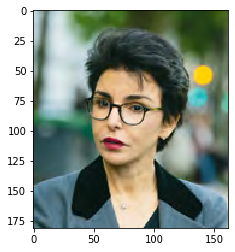

text from page 6 :
 Rachida Dati, maire LRI du 7e arrondissement, hier.   
----------------------------------------------
text from page 6 :
 Rachida Dati, maire LRI du 7e arrondissement, hier.   


In [77]:
mot_cle = 'Dati'
find_image(mot_cle, df, df_copy)